# Item Similarity: Comparison

In this notebook, the goal is to compare different item similarity algorithms from the recpack library in terms of recall, so we can choose the best performing algorithm for candidate generation. 

More specifically, we start by looking at the ItemKNN and TARSItemKNN algorithms in the `Timed` scenario, after which we also investigate whether the `TimedLastItemPrediction` scenario is worth considering.

## Summary
- **`Timed` scenario**
  - Best ItemKNN params: *{K=90, normalize_X=False, normalize_sim=True}*
  - Best TARSItemKNN params: *{K=580, fit_decay=1/10, predict_decay=1/3}*
  - TARSItemKNN has better recall@12, so we will use TARSItemKNN for candidate generation
- **`TimedLastItemPrediction` scenario**
  - Conclusion: overall much better recall than `Timed`, but not suitable for our H&M problem (se end of notebook for more details)
---

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import MinItemsPerUser, MinUsersPerItem
from recpack.scenarios import Timed, TimedLastItemPrediction
from recpack.pipelines import PipelineBuilder
from recpack.algorithms import ItemKNN, KUNN
from recpack.metrics import RecallK, PrecisionK, NDCGK

from helpers.utils import DATA_PATH, customer_hex_id_to_int

In [2]:
transactions = pd.read_parquet(f'{DATA_PATH}/transactions_train.parquet')
# customers = pd.read_parquet(f'{DATA_PATH}/customers.parquet')
# articles = pd.read_parquet(f'{DATA_PATH}/articles.parquet')

In [3]:
test_week = transactions.week.max()
transactions = transactions[transactions.week > test_week - 10]

In [4]:
# print the amount of unique customers and articles
print(f'Unique customers: {transactions["customer_id"].nunique()}')
print(f'Unique articles: {transactions["article_id"].nunique()}')

Unique customers: 437365
Unique articles: 38331


## `ItemKNN` vs `TARSItemKNN` in the `Timed` scenario

### Preprocessing

In [5]:
proc = DataFramePreprocessor(item_ix='article_id', user_ix='customer_id', timestamp_ix='week')
proc.add_filter(MinUsersPerItem(10, item_ix='article_id', user_ix='customer_id'))
proc.add_filter(MinItemsPerUser(10, item_ix='article_id', user_ix='customer_id'))

interaction_matrix = proc.process(transactions)

  0%|          | 0/1228106 [00:00<?, ?it/s]

  0%|          | 0/1228106 [00:00<?, ?it/s]

In [6]:
scenario = Timed(t=test_week, t_validation=test_week - 1, delta_out=None, delta_in=None, validation=True)
scenario.split(interaction_matrix)

In [7]:
builder = PipelineBuilder()
builder.set_data_from_scenario(scenario)

# [50, 600] => best: ItemKNN(K=90,normalize_X=False,normalize_sim=True,pop_discount=None,similarity=cosine), Recall12=0.024356
builder.add_algorithm('ItemKNN', grid={
    'K': [k for k in range(50, 300, 10)],  
    'similarity': ['cosine'],
    'normalize_X': [True, False],
    'normalize_sim': [True]
})

# [50, 600] => best: TARSItemKNN(K=580,fit_decay=0.1,predict_decay=0.3333333333333333,similarity=cosine), Recall12=0.028117
builder.add_algorithm('TARSItemKNN', grid={
    'K': [k for k in range(100, 680, 10)], 
    'similarity': ['cosine'],
    'fit_decay': [1/2, 1/5, 1/10],
    'predict_decay': [1/3, 1/5, 1/10],
})

builder.add_metric('PrecisionK', K=[12, 20, 30, 40])
builder.add_metric('RecallK', K=[12, 20, 30, 40])

builder.set_optimisation_metric('RecallK', K=12)

In [8]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", SparseEfficiencyWarning)

pipeline = builder.build()
pipeline.run()

  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-16 15:08:32,481 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.885s
2022-12-16 15:08:34,365 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.891s
2022-12-16 15:08:36,257 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.958s
2022-12-16 15:08:38,342 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.963s
2022-12-16 15:08:40,456 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.03s
2022-12-16 15:08:42,737 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.05s
2022-12-16 15:08:45,091 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.13s
2022-12-16 15:08:47,606 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.15s
2022-12-16 15:08:50,183 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.24s
2022-12-16 15:08:52,989 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.25s
2022-12-16 15:08:55,813 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.34s
2022-12-16 15:08:58,864 - ba

In [9]:
pipeline.optimisation_results

,identifier,params,recallk_12
0,"ItemKNN(K=50,normalize_X=True,normalize_sim=Tr...","{'K': 50, 'normalize_X': True, 'normalize_sim'...",0.015098
1,"ItemKNN(K=50,normalize_X=False,normalize_sim=T...","{'K': 50, 'normalize_X': False, 'normalize_sim...",0.022547
2,"ItemKNN(K=60,normalize_X=True,normalize_sim=Tr...","{'K': 60, 'normalize_X': True, 'normalize_sim'...",0.015055
3,"ItemKNN(K=60,normalize_X=False,normalize_sim=T...","{'K': 60, 'normalize_X': False, 'normalize_sim...",0.022636
4,"ItemKNN(K=70,normalize_X=True,normalize_sim=Tr...","{'K': 70, 'normalize_X': True, 'normalize_sim'...",0.014897
...,...,...,...
567,"TARSItemKNN(K=670,fit_decay=0.2,predict_decay=...","{'K': 670, 'fit_decay': 0.2, 'predict_decay': ...",0.024195
568,"TARSItemKNN(K=670,fit_decay=0.2,predict_decay=...","{'K': 670, 'fit_decay': 0.2, 'predict_decay': ...",0.023652
569,"TARSItemKNN(K=670,fit_decay=0.1,predict_decay=...","{'K': 670, 'fit_decay': 0.1, 'predict_decay': ...",0.025925
570,"TARSItemKNN(K=670,fit_decay=0.1,predict_decay=...","{'K': 670, 'fit_decay': 0.1, 'predict_decay': ...",0.025667


In [93]:
pipeline.get_metrics()

,precisionk_12,precisionk_20,precisionk_30,precisionk_40,recallk_12,recallk_20,recallk_30,recallk_40
"ItemKNN(K=90,normalize_X=False,normalize_sim=True,pop_discount=None,similarity=cosine)",0.007474,0.006124,0.005108,0.004458,0.024356,0.033519,0.040821,0.047116
"TARSItemKNN(K=580,fit_decay=0.1,predict_decay=0.3333333333333333,similarity=cosine)",0.008380,0.006710,0.005677,0.005007,0.028117,0.036982,0.045927,0.053186


We can see that:
- for `ItemKNN`, we get the highest recall@12 for `K=90, normalize_X=False, normalize_sim=True, pop_discount=None, similarity=cosine`
- for `TARSItemKNN`, we get the highest recall@12 for `K=580, fit_decay=1/10, predict_decay=1/3, similarity=cosine`

From the results, we see that `TARSItemKNN` has overall better recall@12 compared to `ItemKNN`. This makes sense, as `TARSItemKNN` uses time decay to give older interactions less weight, which can be seen as a primitive way of integrating item seasonality into the similarity score.

For clarity, let's plot the recall@12 values for both algorithms in function of K.

### Plotting

In [61]:
# make a new dataframe with the results
results = pipeline.optimisation_results
results['identifier'] = results['identifier'].astype(str)
results['algorithm'] = results.apply(lambda x: 'ItemKNN' if x['identifier'].startswith('ItemKNN') else 'TARSItemKNN', axis=1)
results = pd.concat([
    results, 
    results['params'].astype(str).map(lambda x: dict(eval(x))).apply(pd.Series)
], axis=1) 

In [62]:
# drop al rows where normalize_X is True, normalize_sim is False, fit_decay is not 0.1 and predict_decay is not 1/3
results.drop(
    results[(results['normalize_X'] == True) | 
    (results['normalize_sim'] == False) | 
    ((results['fit_decay'] != 0.1) & (results['algorithm'] == 'TARSItemKNN')) | 
    ((results['predict_decay'] != 1/3) & (results['algorithm'] == 'TARSItemKNN'))].index, inplace=True)

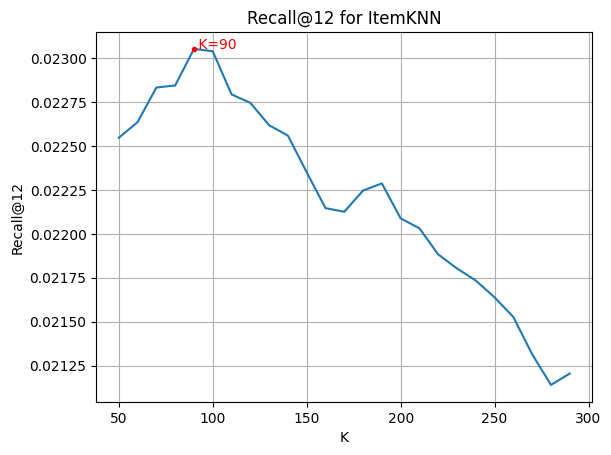

In [91]:
# plot the ItemKNN optimisation results
itemknn_results = results[results['algorithm'] == 'ItemKNN']

ax = sns.lineplot(x='K', y='recallk_12', data=itemknn_results, n_boot=0, errorbar=None, estimator=None)
ax.set_title('Recall@12 for ItemKNN')

# mark the highest y value with a red circle and the corresponding y value
x_max_recall = itemknn_results['K'][(itemknn_results['recallk_12'] == itemknn_results['recallk_12'].max())].values[0]
y_max_recall = itemknn_results['recallk_12'].max()
ax.plot(x_max_recall, y_max_recall, 'ro', markersize=3)
ax.annotate(f" K={x_max_recall}", (x_max_recall, y_max_recall), color="red")
ax.set_ylabel('Recall@12')
ax.grid(True)

plt.show()

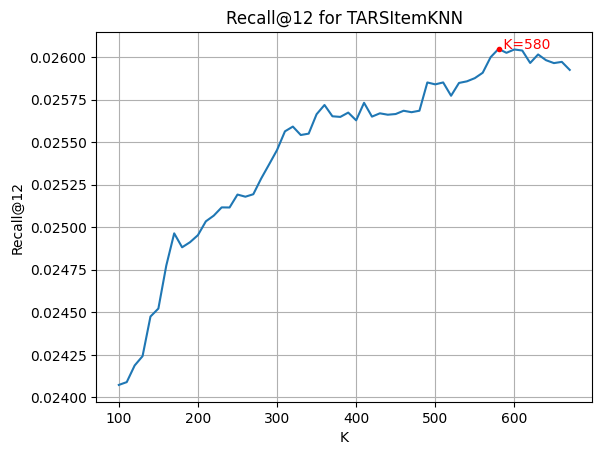

In [90]:
# plot the TARSItemKNN optimisation results
tarsitemknn_results = results[results['algorithm'] == 'TARSItemKNN']

ax = sns.lineplot(x='K', y='recallk_12', data=tarsitemknn_results, n_boot=0, errorbar=None, estimator=None)
ax.set_title('Recall@12 for TARSItemKNN')

# mark the highest y value with a red circle and the corresponding y value
x_max_recall = tarsitemknn_results['K'][(tarsitemknn_results['recallk_12'] == tarsitemknn_results['recallk_12'].max())].values[0]
y_max_recall = tarsitemknn_results['recallk_12'].max()
ax.plot(x_max_recall, y_max_recall, 'ro', markersize=3)
ax.annotate(f" K={x_max_recall}", (x_max_recall, y_max_recall), color="red")
ax.set_ylabel('Recall@12')    
ax.grid(True)

plt.show()

## Try `TimedLastItemPrediction` scenario

In one of the lectures, Bjorn suggested to try out the `TimedLastItemPrediction` scenario instead of `Timed`, and see whether the score improves. That's what we do here.

In [ ]:
# train on everything < test_week - 1, validate on test_week - 1, test on test_week
scenario = TimedLastItemPrediction(t=test_week, t_validation=test_week - 1, validation=True)
scenario.split(interaction_matrix)

/Users/arnotroch/Documents/AIP/ai-project-22-23/venv/lib/python3.10/site-packages/recpack/scenarios/splitters.py:187: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  max_ts_per_user = data.timestamps.max(level=0)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/Users/arnotroch/Documents/AIP/ai-project-22-23/venv/lib/python3.10/site-packages/recpack/scenarios/splitters.py:187: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  max_ts_per_user = data.timestamps.max(level=0)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
builder = PipelineBuilder()
builder.set_data_from_scenario(scenario)

builder.add_algorithm('ItemKNN', grid={
    'K': [k for k in range(50, 150, 10)],  
    'similarity': ['cosine'],
    'normalize_X': [True, False],
    'normalize_sim': [True]
})

builder.add_algorithm('TARSItemKNN', grid={
    'K': [k for k in range(570, 680, 10)], 
    'similarity': ['cosine'],
    'fit_decay': [1/2, 1/5, 1/10],
    'predict_decay': [1/3, 1/5, 1/10],
})


builder.add_metric('PrecisionK', K=[12, 20, 30, 40])
builder.add_metric('RecallK', K=[12, 20, 30, 40])

builder.set_optimisation_metric('RecallK', K=12)

In [ ]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", SparseEfficiencyWarning)

pipeline = builder.build()
pipeline.run()

  0%|          | 0/2 [00:00<?, ?it/s]

2022-11-26 16:01:05,776 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.88s
2022-11-26 16:01:07,874 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.9s
2022-11-26 16:01:10,167 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.95s
2022-11-26 16:01:12,521 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.981s
2022-11-26 16:01:14,937 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.07s
2022-11-26 16:01:17,664 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.09s
2022-11-26 16:01:20,344 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.15s
2022-11-26 16:01:23,267 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.17s
2022-11-26 16:01:26,271 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.25s
2022-11-26 16:01:29,442 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.26s
2022-11-26 16:01:32,692 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.39s
2022-11-26 16:01:36,262 - base -

In [ ]:
pipeline.optimisation_results

,identifier,params,recallk_12
0,"ItemKNN(K=50,normalize_X=True,normalize_sim=Tr...","{'K': 50, 'normalize_X': True, 'normalize_sim'...",0.056492
1,"ItemKNN(K=50,normalize_X=False,normalize_sim=T...","{'K': 50, 'normalize_X': False, 'normalize_sim...",0.076311
2,"ItemKNN(K=60,normalize_X=True,normalize_sim=Tr...","{'K': 60, 'normalize_X': True, 'normalize_sim'...",0.056344
3,"ItemKNN(K=60,normalize_X=False,normalize_sim=T...","{'K': 60, 'normalize_X': False, 'normalize_sim...",0.076014
4,"ItemKNN(K=70,normalize_X=True,normalize_sim=Tr...","{'K': 70, 'normalize_X': True, 'normalize_sim'...",0.056294
...,...,...,...
114,"TARSItemKNN(K=670,fit_decay=0.2,predict_decay=...","{'K': 670, 'fit_decay': 0.2, 'predict_decay': ...",0.091731
115,"TARSItemKNN(K=670,fit_decay=0.2,predict_decay=...","{'K': 670, 'fit_decay': 0.2, 'predict_decay': ...",0.083576
116,"TARSItemKNN(K=670,fit_decay=0.1,predict_decay=...","{'K': 670, 'fit_decay': 0.1, 'predict_decay': ...",0.099244
117,"TARSItemKNN(K=670,fit_decay=0.1,predict_decay=...","{'K': 670, 'fit_decay': 0.1, 'predict_decay': ...",0.094894


In [ ]:
pipeline.get_metrics()

,precisionk_12,precisionk_20,precisionk_30,precisionk_40,recallk_12,recallk_20,recallk_30,recallk_40
"ItemKNN(K=50,normalize_X=False,normalize_sim=True,pop_discount=None,similarity=cosine)",0.006263,0.004779,0.003736,0.003153,0.075152,0.095571,0.112066,0.126120
"TARSItemKNN(K=610,fit_decay=0.1,predict_decay=0.3333333333333333,similarity=cosine)",0.008543,0.006171,0.004791,0.003918,0.102519,0.123416,0.143728,0.156722


### Conclusion

The recall@12 is significantly better in the `TimedLastItemPrediction` scenario compared to the `Timed` scenario. However, I was not sure whether this scenario was applicable to our use case, so I went to the recpack documentation on `TimedLastItemPrediction`, which says the following:

*"Predict users’ last interaction, given information about historical interactions. ... The scenario splits the data such that the last interaction of a user is the target for prediction, while the earlier ones are used for training and as history."*

From this description, it seems to me that this scenario is not well-suited for what we are trying to achieve. The goal for the H&M recommendation problem is to predict **all** interactions a user makes in week $t + 1$, given their interaction history up until week $t$. However, the `TimedLastItemPrediction` scenario targets only a single user interaction for prediction, namely the last interaction that a user performs. For this reason, we disregard the results from this scenario and simply use the best `TARSItemKNN` parameters for the `Timed` scenario in our candidate generation.